In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

from google.colab import drive
drive.mount('/content/drive')
drive_dir = '/content/drive/MyDrive/Data Science/Project 3/'

Mounted at /content/drive


In [2]:
df = pd.read_csv('/content/drive/MyDrive/heart_2020_cleaned.csv')

In [3]:
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


#**Data Prep and Clean-up**

### Label Encoder

In [4]:
heartDisease_le = LabelEncoder()
stroke_le = LabelEncoder()
sex_le = LabelEncoder()
diabetic_le = LabelEncoder()
asthma_le = LabelEncoder()
kidneyDisease_le = LabelEncoder()
skinCancer_le = LabelEncoder()
smoking_le = LabelEncoder()
alcohol_le = LabelEncoder()
race_le = LabelEncoder()
diabetic_le = LabelEncoder()
activity_le = LabelEncoder()
health_le = LabelEncoder()
walk_le = LabelEncoder()
gen_health_le = LabelEncoder()

In [5]:
df['HeartDisease'] = heartDisease_le.fit_transform(df['HeartDisease'])
df['Stroke'] = stroke_le.fit_transform(df['Stroke'])
df['Sex'] = sex_le.fit_transform(df['Sex'])
df['Diabetic'] = diabetic_le.fit_transform(df['Diabetic'])
df['Asthma'] = asthma_le.fit_transform(df['Asthma'])
df['KidneyDisease'] = kidneyDisease_le.fit_transform(df['KidneyDisease'])
df['SkinCancer'] = skinCancer_le.fit_transform(df['SkinCancer'])
df['Smoking'] = smoking_le.fit_transform(df['Smoking'])
df['AlcoholDrinking'] = alcohol_le.fit_transform(df['AlcoholDrinking'])
df['Race'] = race_le.fit_transform(df['Race'])
df['PhysicalActivity'] = activity_le.fit_transform(df['PhysicalActivity'])
df['DiffWalking'] = walk_le.fit_transform(df['DiffWalking'])
df['GenHealth'] = gen_health_le.fit_transform(df['GenHealth'])

In [6]:
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,30.0,0,0,55-59,5,2,1,4,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,0,80 or older,5,0,1,4,7.0,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,1,65-69,5,2,1,1,8.0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,0,75-79,5,0,0,2,6.0,0,0,1
4,0,23.71,0,0,0,28.0,0.0,1,0,40-44,5,0,1,4,8.0,0,0,0


## Dummy Variables

In [7]:
df = pd.concat([df, pd.get_dummies(df['Diabetic'], prefix='Diabetic')], axis=1)
df = pd.concat([df, pd.get_dummies(df['Sex'], prefix='Sex')], axis=1)
df = pd.concat([df, pd.get_dummies(df['AgeCategory'], prefix='AgeCategory')], axis=1)
df = pd.concat([df, pd.get_dummies(df['Race'], prefix='Race')], axis=1)

df = df.drop(columns=['AgeCategory', 'Race', 'Diabetic'])

In [8]:
df_heartDisease = df.groupby('HeartDisease').agg({'HeartDisease': 'count', 'Stroke': 'sum', 'Asthma': 'sum', 'KidneyDisease': 'sum', 'SkinCancer': 'sum', 'Diabetic_2': 'sum', 'Diabetic_3': 'sum'})
df_heartDisease = df_heartDisease.rename({'HeartDisease': 'Count'}, axis=1)
df_heartDisease = df_heartDisease.reset_index()

df_heartDisease['num_stroke_per_10k'] = (df_heartDisease['Stroke']/df_heartDisease['Count']) * 1000
df_heartDisease['num_asthma_per_10k'] = (df_heartDisease['Asthma']/df_heartDisease['Count']) * 1000
df_heartDisease['num_kidney_per_10k'] = (df_heartDisease['KidneyDisease']/df_heartDisease['Count']) * 1000
df_heartDisease['num_skin_per_10k'] = (df_heartDisease['SkinCancer']/df_heartDisease['Count']) * 1000
df_heartDisease['num_diabetic2_per_10k'] = (df_heartDisease['Diabetic_2']/df_heartDisease['Count']) * 1000

In [9]:
df['Is_Diabetic'] = (df['Diabetic_2'] == 1) | (df['Diabetic_3'] == 1)

#**Create Train Test Split**

In [10]:
heartDisease_df = df[df['HeartDisease'] == 1]
train_heartDisease, test_heartDisease = train_test_split(heartDisease_df, train_size=0.7)
num_heartDisease = len(train_heartDisease)

no_heartDisease_df = df[df['HeartDisease'] == 0]
train_noHeartDisease, test_noHeartDisease = train_test_split(no_heartDisease_df, train_size=num_heartDisease)

train_df = pd.concat([train_heartDisease, train_noHeartDisease])
test_df = pd.concat([test_heartDisease, test_noHeartDisease])

### Choose factors for X and Y

In [11]:
df.columns

Index(['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex',
       'PhysicalActivity', 'GenHealth', 'SleepTime', 'Asthma', 'KidneyDisease',
       'SkinCancer', 'Diabetic_0', 'Diabetic_1', 'Diabetic_2', 'Diabetic_3',
       'Sex_0', 'Sex_1', 'AgeCategory_18-24', 'AgeCategory_25-29',
       'AgeCategory_30-34', 'AgeCategory_35-39', 'AgeCategory_40-44',
       'AgeCategory_45-49', 'AgeCategory_50-54', 'AgeCategory_55-59',
       'AgeCategory_60-64', 'AgeCategory_65-69', 'AgeCategory_70-74',
       'AgeCategory_75-79', 'AgeCategory_80 or older', 'Race_0', 'Race_1',
       'Race_2', 'Race_3', 'Race_4', 'Race_5', 'Is_Diabetic'],
      dtype='object')

In [12]:
X_train = train_df[['AlcoholDrinking', 'DiffWalking', 'Smoking', 'Stroke', 'KidneyDisease', 'Asthma', 'Is_Diabetic',
                  'Sex', 'AgeCategory_18-24', 'AgeCategory_25-29',
                  'AgeCategory_30-34', 'AgeCategory_35-39', 'AgeCategory_40-44',
                  'AgeCategory_45-49', 'AgeCategory_50-54', 'AgeCategory_55-59',
                  'AgeCategory_60-64', 'AgeCategory_65-69', 'AgeCategory_70-74',
                  'AgeCategory_75-79', 'AgeCategory_80 or older', 'Race_0', 'Race_1',
                  'Race_2', 'Race_3', 'Race_4', 'Race_5']]
X_test = test_df[['AlcoholDrinking', 'DiffWalking', 'Smoking', 'Stroke', 'KidneyDisease', 'Asthma', 'Is_Diabetic',
                  'Sex', 'AgeCategory_18-24', 'AgeCategory_25-29',
                  'AgeCategory_30-34', 'AgeCategory_35-39', 'AgeCategory_40-44',
                  'AgeCategory_45-49', 'AgeCategory_50-54', 'AgeCategory_55-59',
                  'AgeCategory_60-64', 'AgeCategory_65-69', 'AgeCategory_70-74',
                  'AgeCategory_75-79', 'AgeCategory_80 or older', 'Race_0', 'Race_1',
                  'Race_2', 'Race_3', 'Race_4', 'Race_5']]
y_train = train_df['HeartDisease']
y_test = test_df['HeartDisease']

#**Logistic Regression**

### Train Model

In [13]:
logr = LogisticRegression(max_iter=10000)
logr.fit(X_train, y_train)

logr_preds = logr.predict(X_test)
logr_proba_preds = logr.predict_proba(X_test)[:,1]

### Model Evaluation

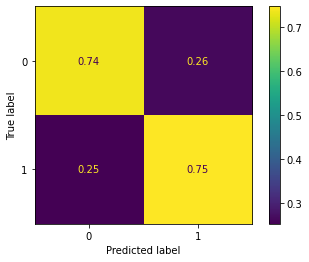

In [14]:
ConfusionMatrixDisplay.from_predictions(y_test, logr_preds, normalize='true')
plt.show()

In [15]:
print(classification_report(y_test, logr_preds))

              precision    recall  f1-score   support

           0       0.99      0.74      0.84    273261
           1       0.08      0.75      0.14      8212

    accuracy                           0.74    281473
   macro avg       0.53      0.74      0.49    281473
weighted avg       0.96      0.74      0.82    281473



In [16]:
accuracy_score(y_test, logr_preds)

0.7369197045542556

In [17]:
roc_auc_score(y_test, logr_preds)

0.7420821736040195

### Coefficient Analysis

In [18]:
logr.coef_

array([[-0.26221986,  0.77404294,  0.50215842,  1.39111473,  0.80440245,
         0.51701109,  0.69191093,  0.73543718, -1.74330139, -1.49006443,
        -1.15282064, -0.965046  , -0.67227664, -0.34299341,  0.10188758,
         0.35271762,  0.6620397 ,  0.9292337 ,  1.18598555,  1.42370185,
         1.71106572,  0.1419433 , -0.40450601, -0.06302753,  0.11707638,
         0.14508721,  0.06355588]])

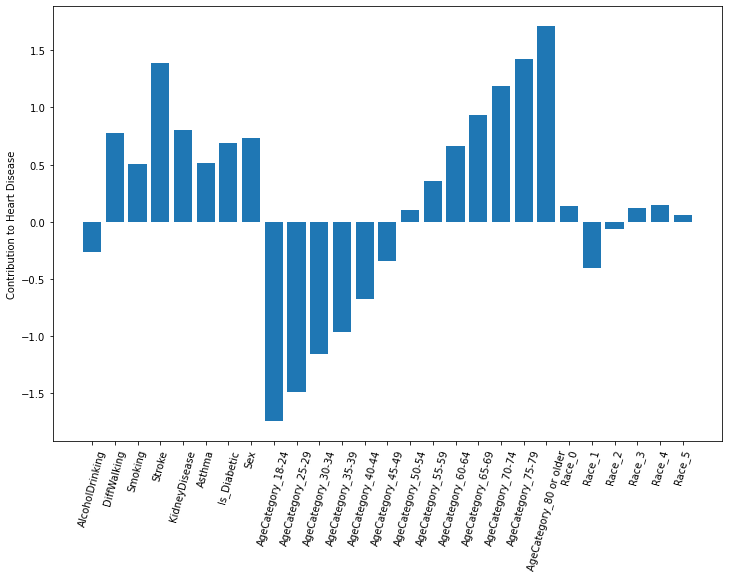

In [19]:
plt.figure(figsize=(12,8))
plt.bar(x=X_train.columns,
        height=logr.coef_[0])
plt.ylabel('Contribution to Heart Disease')
plt.xticks(rotation=75);

#**Nearest Neighbors Model**

### Scale the Data

In [20]:
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)

### Fit the Model

In [21]:
knn_params = {'n_neighbors': [2, 5, 10, 20, 30, 40, 50]}

knn = KNeighborsClassifier()

knn_grid_search = GridSearchCV(knn, knn_params)

knn_grid_search.fit(X_train_scaled, y_train)

knn_preds = knn_grid_search.predict(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


### Model Evaluation

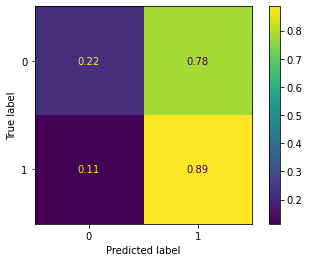

In [22]:
ConfusionMatrixDisplay.from_predictions(y_test, knn_preds, normalize='true')
plt.show()

In [23]:
knn_grid_search.best_params_

{'n_neighbors': 50}

In [24]:
print(classification_report(y_test, knn_preds))

              precision    recall  f1-score   support

           0       0.98      0.22      0.36    273261
           1       0.03      0.89      0.06      8212

    accuracy                           0.24    281473
   macro avg       0.51      0.55      0.21    281473
weighted avg       0.96      0.24      0.35    281473



In [25]:
accuracy_score(y_test, knn_preds)

0.23918457542997018

In [26]:
roc_auc_score(y_test, knn_preds)

0.5527060372490588

# **Decision Tree Model**

### Fit the Model

In [27]:
dtc = DecisionTreeClassifier()

dtc_parms = {'max_depth': [2, 5, 10, 25, 50, 100],
             'min_samples_split': [2, 5, 10, 25, 50, 100],
             'min_samples_leaf': [2, 5, 10, 25, 50, 100]}

dtc_grid_search = GridSearchCV(dtc, dtc_parms)

dtc_grid_search.fit(X_train, y_train)

dtc_preds = dtc_grid_search.predict(X_test)

### Model Evaluation

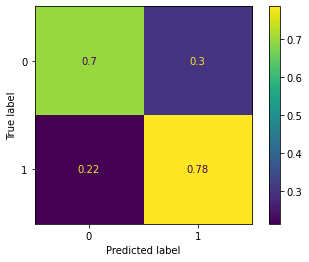

In [28]:
ConfusionMatrixDisplay.from_predictions(y_test, dtc_preds, normalize='true')
plt.show()

In [29]:
dtc_grid_search.best_params_

{'max_depth': 25, 'min_samples_leaf': 25, 'min_samples_split': 2}

In [30]:
print(classification_report(y_test, dtc_preds))

              precision    recall  f1-score   support

           0       0.99      0.70      0.82    273261
           1       0.07      0.78      0.13      8212

    accuracy                           0.70    281473
   macro avg       0.53      0.74      0.48    281473
weighted avg       0.96      0.70      0.80    281473



In [31]:
accuracy_score(y_test, dtc_preds)

0.7003407076344801

In [33]:
roc_auc_score(y_test, dtc_preds)

0.7413144088279182

# **Random Forest Classifier Model**

### Fit the Model

In [34]:
rfc = RandomForestClassifier()

rfc_params = {'max_depth': [25, 50, 100],
             'min_samples_split': [ 25, 50, 100],
             'min_samples_leaf': [25, 50, 100],
             'n_estimators': [300, 350, 400]}

rfc_grid_search = GridSearchCV(rfc, rfc_params)

rfc_grid_search.fit(X_train, y_train)

rfc_grid_search_preds = rfc_grid_search.predict(X_test)

### Model Evaluation

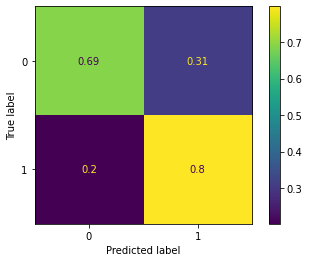

In [35]:
ConfusionMatrixDisplay.from_predictions(y_test, rfc_grid_search_preds, normalize='true')
plt.show()

In [36]:
rfc_grid_search.best_params_

{'max_depth': 25,
 'min_samples_leaf': 25,
 'min_samples_split': 100,
 'n_estimators': 400}

In [42]:
accuracy_score(y_test, rfc_grid_search_preds)

0.6933098378885364

In [40]:
roc_auc_score(y_test, rfc_grid_search_preds)

0.7442486284249177

# **Gradient Boosting Classifier**

### Fit the Model

In [202]:
#gbc = GradientBoostingClassifier()

#gbc_params = {'max_depth': [2, 5, 10, 25, 50, 100],
              #'min_samples_split': [2, 5, 10, 25, 50, 100],
              #'min_samples_leaf': [2, 5, 10, 25, 50, 100],
              #'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], 
              #'learning_rate': [0.05, 0.25, 0.5, 0.75, 1]}

#gbc_grid_search = GridSearchCV(gbc, gbc_params)

#gbc_grid_search.fit(X_train, y_train)

#gbc_grid_search_preds = gbc_grid_search.predict(X_test)

### Model Evaluation

In [203]:
#gbc_grid_search.best_params_

In [204]:
#ConfusionMatrixDisplay.from_predictions(y_test, gbc_grid_search_preds, normalize='true')
#plt.show()

# **Ensemble Model**

### Fit Model

In [39]:
vote_clf = VotingClassifier([('logr', logr), ('dtc', dtc_grid_search.best_estimator_), ('rfc', rfc_grid_search.best_estimator_)])

vote_clf.fit(X_train, y_train)

vote_preds = vote_clf.predict(X_test)

### Model Evaluation

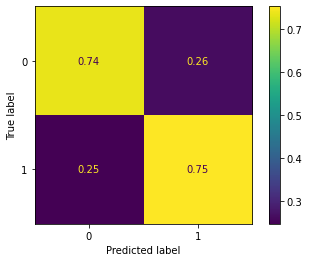

In [206]:
ConfusionMatrixDisplay.from_predictions(y_test, vote_preds, normalize='true')
plt.show()

In [207]:
accuracy_score(y_test, vote_preds)

0.7368983881224842

In [41]:
roc_auc_score(y_test, vote_preds)

0.7446492869607774

In [47]:
test_df['LogrPreds'] = logr_preds

In [48]:
test_df['dtcpreds'] = dtc_preds

In [49]:
test_df['rfcpreds'] = rfc_grid_search_preds

In [55]:
CorrectPredsDf = test_df[test_df['LogrPreds'] == test_df['HeartDisease']]

In [56]:
CorrectPredsDf

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,PhysicalActivity,...,Race_0,Race_1,Race_2,Race_3,Race_4,Race_5,Is_Diabetic,LogrPreds,dtcpreds,rfcpreds
56168,1,25.24,1,0,0,30.0,0.0,1,0,1,...,0,0,1,0,0,0,False,1,1,1
317214,1,32.01,0,0,0,30.0,0.0,1,0,0,...,0,0,0,1,0,0,True,1,1,1
228248,1,32.89,1,0,0,0.0,0.0,0,1,0,...,0,0,0,0,0,1,True,1,1,1
177951,1,29.05,0,0,0,2.0,0.0,0,1,1,...,0,0,0,0,0,1,False,1,1,1
3887,1,33.10,1,0,0,25.0,25.0,0,1,0,...,0,0,1,0,0,0,False,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36990,0,27.46,0,0,0,30.0,3.0,1,1,1,...,0,0,0,0,0,1,False,0,0,1
243168,0,25.09,0,0,0,2.0,0.0,0,1,1,...,0,0,0,0,0,1,False,0,0,0
14254,0,20.98,0,0,0,0.0,7.0,0,0,1,...,0,1,0,0,0,0,False,0,0,0
229479,0,34.33,0,0,0,30.0,15.0,0,0,0,...,0,0,0,0,0,1,False,0,0,0


In [57]:
IncorrectPredsDf = test_df[test_df['LogrPreds'] != test_df['HeartDisease']]


In [59]:
IncorrectPredsDf.head(20)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,PhysicalActivity,...,Race_0,Race_1,Race_2,Race_3,Race_4,Race_5,Is_Diabetic,LogrPreds,dtcpreds,rfcpreds
3931,1,26.50,0,0,0,0.0,0.0,0,1,1,...,0,0,0,0,0,1,False,0,0,0
173144,1,29.76,0,0,0,0.0,12.0,0,0,1,...,0,0,0,0,0,1,False,0,0,0
51513,1,23.03,0,0,0,0.0,0.0,0,0,1,...,0,0,1,0,0,0,False,0,0,0
160203,1,51.69,1,0,0,0.0,7.0,0,0,1,...,0,0,1,0,0,0,False,0,0,0
80966,1,21.79,0,0,0,0.0,3.0,0,0,1,...,0,0,0,0,0,1,False,0,0,0
196495,1,20.90,1,0,0,0.0,10.0,0,0,0,...,0,0,0,0,0,1,False,0,0,0
15960,1,30.42,0,0,0,4.0,0.0,0,0,1,...,0,0,0,0,0,1,False,0,0,0
187428,1,29.26,0,0,0,1.0,0.0,0,0,1,...,0,0,0,0,0,1,False,0,0,0
275416,1,30.50,1,0,0,0.0,20.0,0,0,1,...,0,0,0,0,0,1,False,0,0,0
181727,1,26.37,0,0,0,2.0,12.0,0,0,1,...,0,0,0,0,0,1,True,0,0,0
